**Importing libraries**

In [4]:
import numpy as np
from sklearn.svm import SVR
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc
import os
from glob import glob
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn import svm
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
#from DataAugmentation import augment

**Loading dataset**

In [12]:
bowl_images=glob(os.path.join('bowl/*.jpg'))
plate_images=glob(os.path.join('plate/*.jpg'))
neg_images=glob(os.path.join('negative/*.jpg'))

#out1=pd.read_csv('Augmented_data/bowl/localization_circle.csv')
#out2=pd.read_csv('Augmented_data/plate/localization_circle.csv')
output=np.zeros((len(bowl_images)+len(plate_images)+len(neg_images),1))
#output[:len(bowl_images),0]=out1['x']
#output[:len(bowl_images),1]=out1['y']
#output[len(bowl_images):,0]=out2['x']
#output[len(bowl_images):,1]=out2['y']
kernel = np.ones((5,5),np.float32)/25
temp=cv2.imread('bowl/01.jpg')
temp=cv2.resize(temp, (0,0), fx=0.1, fy=0.1, interpolation = cv2.INTER_AREA)



data=np.zeros((len(bowl_images)+len(plate_images)+len(neg_images),temp.shape[0],temp.shape[1],temp.shape[2]))   
data=np.array(data,np.uint8)
for i in range(len(neg_images)):
    temp=cv2.imread(neg_images[i])
    if not (temp.shape[0]==2464):
        temp=cv2.resize(temp, (3280,2464))
    temp= cv2.filter2D(temp,-1,kernel)
    temp=cv2.resize(temp, (0,0), fx=0.1, fy=0.1, interpolation = cv2.INTER_AREA)
    data[i,:,:,:]=temp
    output[i,0]=0
    
    
for i in range(len(bowl_images)):
    temp=cv2.imread(bowl_images[i])
    if not (temp.shape[0]==2464):
        temp=cv2.resize(temp, (3280,2464))
    temp= cv2.filter2D(temp,-1,kernel)
    temp=cv2.resize(temp, (0,0), fx=0.1, fy=0.1, interpolation = cv2.INTER_AREA)
    data[i+len(neg_images),:,:,:]=temp
    output[i+len(neg_images),0]=1

for i in range(len(plate_images)):
    temp=cv2.imread(plate_images[i])
    if not (temp.shape[0]==2464):
        temp=cv2.resize(temp, (3280,2464))
    temp= cv2.filter2D(temp,-1,kernel)
    temp=cv2.resize(temp, (0,0), fx=0.1, fy=0.1, interpolation = cv2.INTER_AREA)
    data[i+len(bowl_images)+len(neg_images),:,:,:]=temp
    output[i+len(bowl_images)+len(neg_images),0]=2
    


**Data augmentation for training deep learning model on low number of training samples**

In [4]:
aug=10
new_d=np.zeros((data.shape[0]*aug,data.shape[1],data.shape[2],data.shape[3]))
new_output=np.zeros(data.shape[0]*aug)
for i in range(data.shape[0]):
    image=data[i,:,:,:]
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    new_d[i*aug:(i+1)*aug,:,:,:]=augment(image,amplify=aug)
    if output[i]==0:
        new_output[i*aug:(i+1)*aug]=[0]*aug
    if output[i]==1:
        new_output[i*aug:(i+1)*aug]=[1]*aug
    if output[i]==2:
        new_output[i*aug:(i+1)*aug]=[2]*aug


In [5]:
data=new_d
output=new_output
print(data.shape)
print(output.shape)

(7000, 246, 328, 3)
(7000,)


**Loading the inception model and its weights**

In [ ]:
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(246,328, 3))
data_temp = np.array([scipy.misc.imresize(data[i], (246,328, 3)) 
                            for i in range(0, len(data))]).astype('float32')
inception_input = preprocess_input(data_temp)
features = model.predict(inception_input)
features = np.squeeze(features)

**Splitting the dataset**

In [41]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]*X_test.shape[3])

In [6]:
y_train[:,0:2]=y_train[:,0:2]/10
y_test[:,0:2]=y_test[:,0:2]/10

In [44]:
y_train.shape

(980,)

In [2]:
X_train=np.load('X_train.npy')
X_test=np.load('X_test.npy')
y_train=np.load('y_train.npy')
y_test=np.load('y_test.npy')

**Creating the fc layer for training on top of inception model**

In [7]:
#regressor=KNeighborsRegressor()
#regressor.fit(X_train,y_train[:,0:2])
#print(regressor.score(X_test,y_test[:,0:2]))
#classifier=KNeighborsClassifier()
#classifier=svm.SVC()
classifier=MLPClassifier(hidden_layer_sizes=(200))
classifier.fit(X_train,y_train[:])
print(classifier.score(X_test,y_test[:]))

0.928571428571


In [4]:
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(246,328, 3))

**Plotting results**

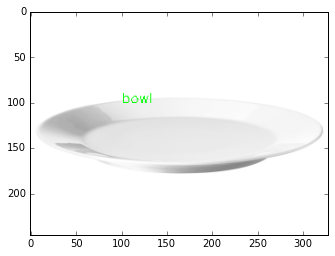

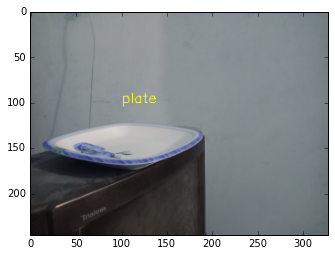

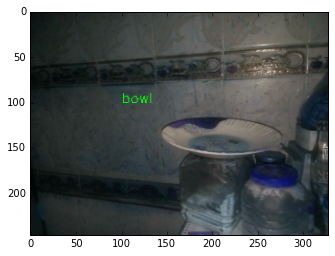

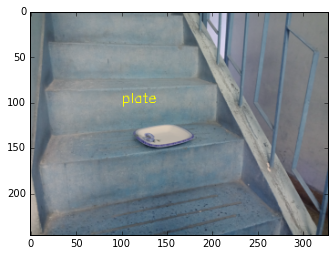

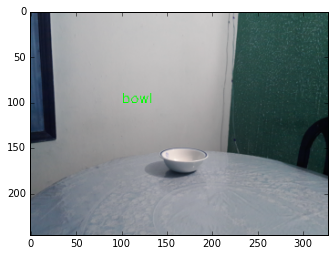

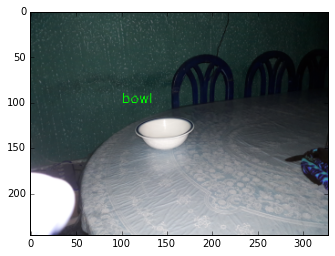

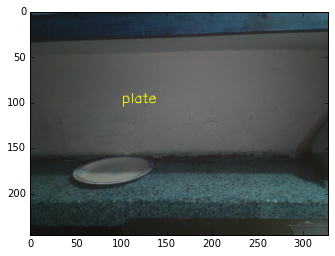

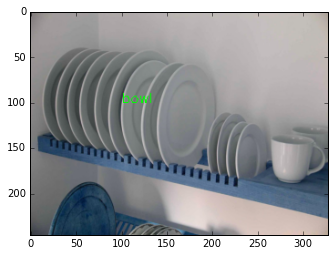

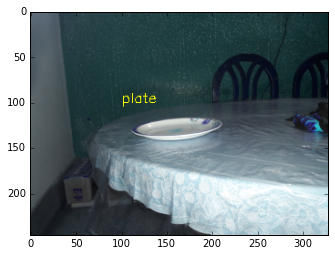

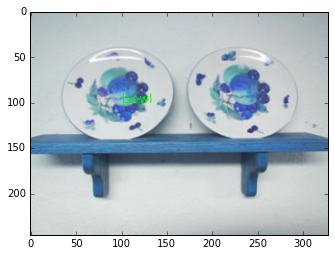

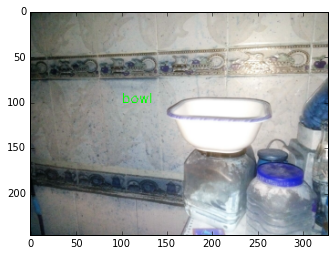

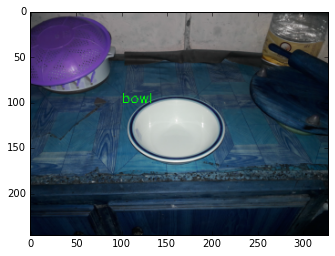

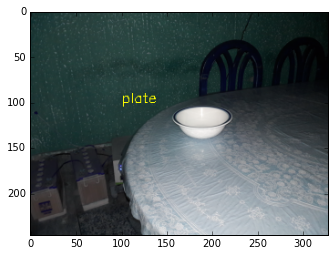

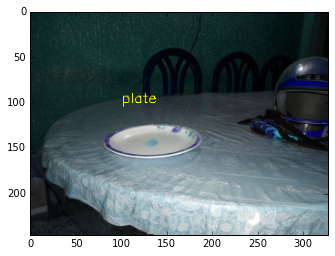

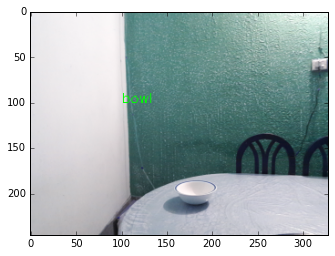

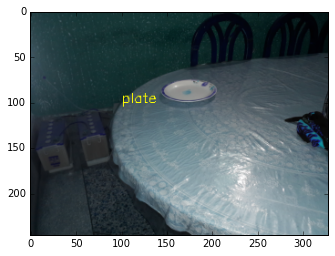

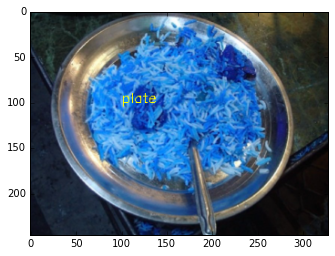

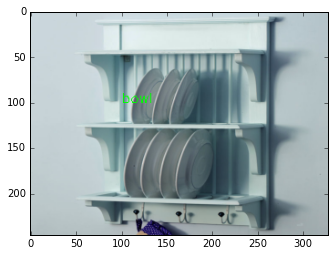

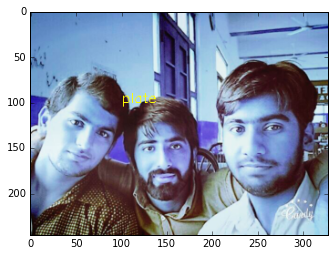

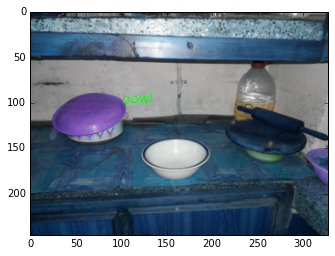

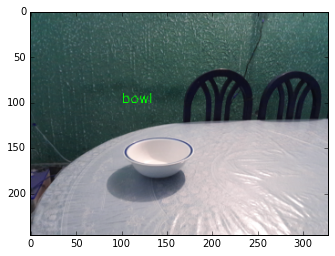

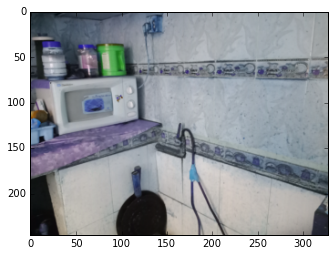

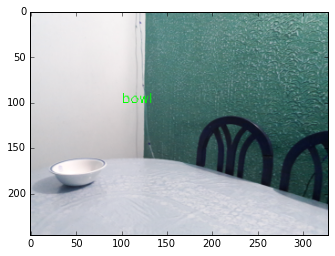

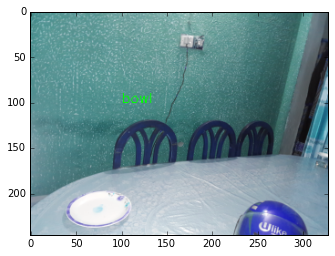

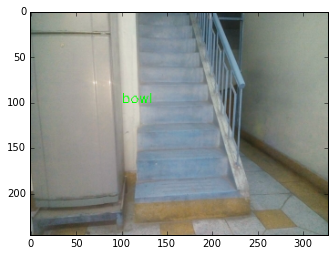

In [8]:
kernel = np.ones((5,5),np.float32)/25
images=glob(os.path.join('test/*.jpg'))
random.shuffle(images)
for i in range(0,len(images)):
    img=cv2.imread(images[i])
    if not (img.shape[0]==2464):
        img=cv2.resize(img, (3280,2464))
    img= cv2.filter2D(img,-1,kernel)
    img=cv2.resize(img, (0,0), fx=0.1, fy=0.1, interpolation = cv2.INTER_AREA)
    tmp=img.reshape(1,246,328,3).astype('float32')
    inception_input = preprocess_input(tmp)
    fd = model.predict(inception_input)
    fd=fd.reshape(1,6*8*2048)
    #fd=img.reshape(1,img.shape[0]*img.shape[1])
    #temp=regressor.predict(fd)
    #temp=classifier1.predict(fd.reshape(1,img.shape[0]*img.shape[1]))
    #print(temp)
    text_temp=classifier.predict(fd)
    if (text_temp==0):
        text=' '
        color=0
    if (text_temp==1):
        text='bowl'
        color=0     
    if (text_temp==2):
        text='plate'
        color=255 
    #temp2=cv2.circle(img, (int(temp1),int(temp2)), 20, (0,255,0), thickness=10)
    #cv2.putText(img,text, (int(temp[0,0]-106/2),int(temp[0,1]-64/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (color,255,0))
    cv2.putText(img,text, (100,100), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (color,255,0))
    #temp2=cv2.rectangle(img,(int(temp[0,0]-98/2),int(temp[0,1]-55/2)),(int(temp[0,0]+98/2),int(temp[0,1]+55/2)),(0,255,0),2)
    plt.imshow(img)
    plt.show()
    #cv2.imwrite('Outputs/'+str(i)+'.jpg',temp2)

In [21]:
temp=cv2.imread(bowl_images[21])
print(temp.shape)

(3456, 4608, 3)


In [49]:
np.save('X_train.npy',X_train)
np.save('X_test.npy',X_test)
np.save('y_train.npy',y_train)
np.save('y_test.npy',y_test)